In [ ]:
!pip3 install --upgrade --user google-cloud-aiplatform umap-learn tqdm pypdf

In [2]:
import IPython
from IPython.display import Markdown, display
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
from vertexai.preview.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel('gemini-pro')

## Download a PDF and Convert to Text

In [2]:
import urllib.request

# download alphabet's annual pdf report
url = "https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63"
file = "2022-alphabet-annual-report.pdf"

urllib.request.urlretrieve(f"{url}/{file}", filename=f"{file}")

('2022-alphabet-annual-report.pdf',
 <http.client.HTTPMessage at 0x7fca64699330>)

In [ ]:
!pip install PyPDF2
import PyPDF2

# Open the PDF file in binary mode
with open('2022-alphabet-annual-report.pdf', 'rb') as file:
    # Create a PdfFileReader object
    pdf_reader = PyPDF2.PdfReader(file)
    pdf_texts = [p.extract_text().strip() for p in pdf_reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]

    print(pdf_texts[0])

Split PDF into chunks so that we can create embedding out of them. The embedding's APIs and the LLM have token limits, that's why we need to split the text into smaller units as opposed to sending the whole text.

In [4]:
!pip install langchain sentence-transformers
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

  Attempting uninstall: requests-toolbelt
    Found existing installation: requests-toolbelt 0.10.1
    Uninstalling requests-toolbelt-0.10.1:
      Successfully uninstalled requests-toolbelt-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
5
Year in Review 2022
Multisearch
With multisearch, people can now 
search with both images and text  
at the same time in Google Lens.

Total chunks: 489


Create more chunks if the size of the existing chunk is too big. In this case, we define too big as 256 tokens.

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

5 year in review 2022 multisearch with multisearch, people can now search with both images and text at the same time in google lens.

Total chunks: 511


## Install and initialize the embeddings database

To store the embeddings we use Chroma, an open-source embeddings database that makes it straightforward to store embeddings.

In [ ]:
!pip3 install chromadb==0.5.3
!pip3 install google-generativeai
import chromadb
import os
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import chromadb.utils.embedding_functions as embedding_functions

# import getpass
# import os

# getpass will prompt for an API Key
# The API Key is needed for Chroma DB
# API_KEY = getpass.getpass("Provide your Google API Key")

# embedding_function = embedding_functions.GooglePalmEmbeddingFunction(api_key=creds.token)

In [8]:
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

[[-0.03299040347337723, -0.03994394838809967, 0.02768322080373764, -0.020394684746861458, 0.010316920466721058, -0.013435319997370243, -0.11188780516386032, 0.0020084811840206385, -0.008219876326620579, -0.054634515196084976, 0.05009115859866142, 0.060834359377622604, 0.050288472324609756, 0.04027774557471275, 0.0002621527237351984, -0.01453626248985529, -0.054342564195394516, 0.0022568206768482924, -0.03845825418829918, -0.053221721202135086, 0.0584506019949913, -0.04633062705397606, 0.11275571584701538, -0.0909026712179184, -0.005574648734182119, 0.02450973354279995, -0.14071720838546753, -0.09735380113124847, -0.0076984865590929985, 0.018437139689922333, -5.31673249497544e-05, 0.0346691757440567, -0.006346573121845722, 0.11858687549829483, -0.0844186320900917, 0.0539005771279335, -0.06958915293216705, 0.0504479855298996, -0.010030870325863361, 0.016402777284383774, -0.042457979172468185, -0.036958418786525726, -0.03685655817389488, -0.059337131679058075, 0.03196948766708374, 0.02155

## Create embeddings and store them in the chroma database

In [9]:
chroma_client = chromadb.Client()
print("collection")
chroma_collection = chroma_client.create_collection("alphabet_annual_report_2022", embedding_function=embedding_function)
print("created")
ids = [str(i) for i in range(len(token_split_texts))]
print("adding")
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

collection
created
adding


511

## Perform an embeddings search on the chroma db database

In [10]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367


for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 

## Use a RAG to answer the question given the information that was looked up from the database

In [11]:
def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about information contained in an annual report.\n'
    f'You will be shown the user\'s question, and the relevant information from the annual report.\n'
    f'Answer the user\'s question using only this information.\n\n'
    f'Question: {query}. \n Information: {information}')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

response = rag(query=query, retrieved_documents=retrieved_documents, model=model)
print(response)

The total revenue was $282,836 million in 2022. This represents a 10% increase from the $257,637 million in revenue in 2021. 


## Explore embeddings distribution with user queries

Use the python library `umap` to reduce the dimensions of our embeddings to two dimensions, so that we can see how close they are represented in a graph. Then we try different queries to see how different queries relate to the existing embedding space. This can give us an intuition about whether the answer might be found in the embeddings space.

### Transform embeddigns into a two-dimensional space

In [12]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 511/511 [00:06<00:00, 74.54it/s] 


### Plot Them

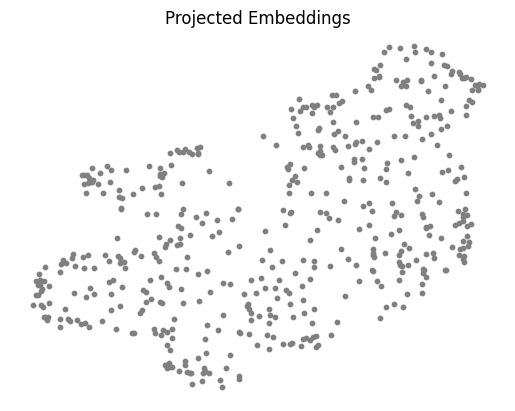

In [13]:
import matplotlib.pyplot as plt

def plot(title='Projected Embeddings', projected_dataset_embeddings=[], projected_query_embedding=[], projected_retrieved_embeddings=[]):
    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    if len(projected_query_embedding) > 0:
        plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    if len(projected_retrieved_embeddings) > 0:
        plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{title}')
    plt.axis('off')

plot(projected_dataset_embeddings=projected_dataset_embeddings)

Ask the same question to the database again, but this time retrieve the embeddings in addition to the documents.

In [14]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367

for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 0

Embed the question and answer and transform it into two dimentions.

In [15]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 129.69it/s]


Plot the projected query and retrieved documents in the embedding space.

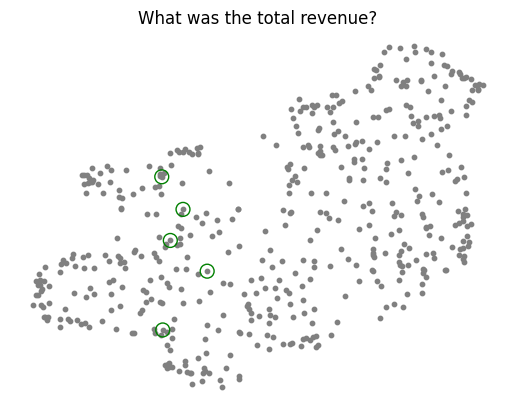

In [16]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

### Another Example

In [17]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

to irrelevance over time, especially in technology, where change tends to be revolutionary, not evolutionary. people thought we were crazy when we acquired youtube and android and when we launched chrome, but those efforts have matured into major platforms for digital video and mobile devices and a safer, popular browser. we continue to look toward the future and to invest for the long term within each of our segments. as we said in the original founders ’ letter, we will not shy away from high - risk, high - reward projects that we believe in, as they are the key to our long - term success. the power of ai we believe that ai is a foundational and transformational technology that will provide compelling and helpful benefits to people and society through its capacity to assist, complement, empower, and inspire people in almost every field of human endeavor. as

are making across our businesses, such as in ai, reflect our ongoing efforts to innovate and provide products and services that

In [18]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 155.00it/s]


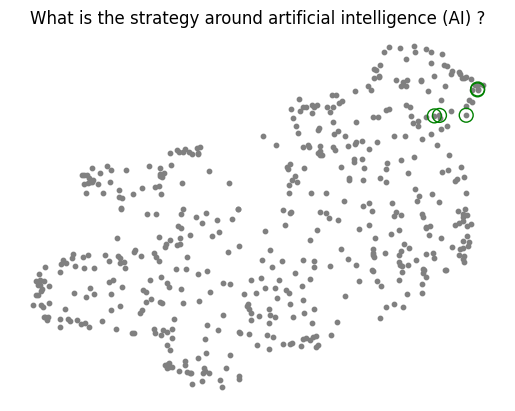

In [19]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Another example:

our operating results have fluctuated, and may in the future fluctuate, as a result of a number of factors, many outside of our control, including the cyclicality and seasonality in our business and geopolitical events. as a result, comparing our operating results ( including our expenses as a percentage of our revenues ) on a period - to - period basis may not be meaningful, and our past results should not be relied on as an indication of our future performance. consequently, our operating results in future quarters may fall below expectations. acquisitions, joint ventures, investments, and divestitures could result in operating difficulties, dilution, and other consequences that could harm our business, financial condition, and operating results. acquisitions, joint ventures, investments, and divestitures are important elements of our overall corporate strategy and use of capital,

customer contracts with commitments for performance obligations, including our estimate of the remainin

100%|██████████| 5/5 [00:00<00:00, 183.58it/s]


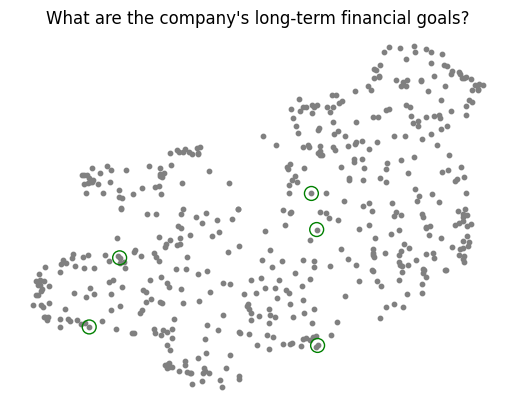

In [20]:
query = "What are the company's long-term financial goals?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Now, let's use an unrelated query and we'll observe how the results are more scattered around. Notice that the algorithm always returns close neighbors even if they are far appart. This is an indication that is returning results that are not necesseraly related to the query.


other bets 753 1, 068 hedging gains ( losses ) 149 1, 960 total revenues $ 257, 637 $ 282, 836

we continue to make significant research and development investments in areas of strategic focus as we seek to develop new, innovative offerings and improve our existing offerings across our businesses. we also expect to continue to invest in our technical infrastructure, including servers, network equipment, and data centers, to support the growth of our business and our long - term initiatives, in particular in support of ai. in addition acquisitions and strategic investments contribute to the breadth and depth of our offerings, expand our expertise in engineering and other functional areas, and build strong partnerships around strategic initiatives. for example, in september 2022 we closed the acquisition of mandiant to help expand our offerings in dynamic cyber defense and response. zwe face continuing changes in regulatory conditions, laws, and public policies, which could affect our bu

100%|██████████| 5/5 [00:00<00:00, 140.04it/s]


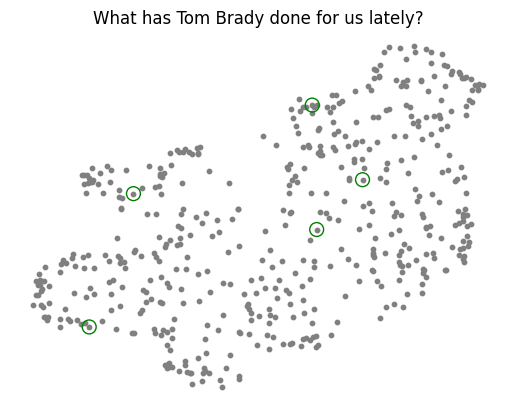

In [21]:
query = "What has Tom Brady done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

## Query Augmentation

One way of improving the results from queries is by getting more results of similar queries. This can be done either by creating similar queries or by sending an answer of what you might expect, so that you attach more context. In this task, you learn to expand your queries leveraging LLMs to do the heavy lifting.

Augment the query with a probable answer to give more context to the vector search.

In [22]:
def augment_query_generated(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Provide an example answer to the given question, that might be found in a document like an annual report.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query, model)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

Was there significant turnover in the executive team? ## Executive Team Turnover

The company experienced minimal executive team turnover in the past year. The Chief Executive Officer (CEO), [Name], has been in their role for [Number] years and brings a wealth of experience to the company. The Chief Financial Officer (CFO), [Name], has been with the company for [Number] years and provides strong financial leadership. The Chief Operating Officer (COO), [Name], has [Number] years of experience in the industry and oversees the day-to-day operations of the company. 

The executive team is highly experienced and well-positioned to lead the company through its next phase of growth. The stability of the executive team provides continuity and ensures that the company's strategic goals are being executed effectively. 



Perform the query with the new augmented query,

In [23]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

item 15 ( collectively referred to as the “ consolidated financial statements ” ). in our opinion, the consolidated financial statements present fairly, in all material respects, the financial position of the company at december 31, 2021 and 2022, and the results of its operations and its cash flows for each of the three years in the period ended december 31, 2022, in conformity with u. s. generally accepted accounting principles. we also have audited, in accordance with the standards of the public company accounting oversight board ( united states ) ( pcaob ), the company ’ s internal control over financial reporting as of december 31, 2022, based on criteria established in internal control — integrated framework issued by the committee of sponsoring organizations of the treadway commission ( 2013 framework ), and our report dated february 2, 2023 expressed an unqualified opinion thereon. basis for opinion

/ s / amie thuener o ’ t oolevice president and chief accounting officer ( pri

Search for embeddings for the augmented query.


In [24]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

item 15 ( collectively referred to as the “ consolidated financial statements ” ). in our opinion, the consolidated financial statements present fairly, in all material respects, the financial position of the company at december 31, 2021 and 2022, and the results of its operations and its cash flows for each of the three years in the period ended december 31, 2022, in conformity with u. s. generally accepted accounting principles. we also have audited, in accordance with the standards of the public company accounting oversight board ( united states ) ( pcaob ), the company ’ s internal control over financial reporting as of december 31, 2022, based on criteria established in internal control — integrated framework issued by the committee of sponsoring organizations of the treadway commission ( 2013 framework ), and our report dated february 2, 2023 expressed an unqualified opinion thereon. basis for opinion

/ s / amie thuener o ’ t oolevice president and chief accounting officer ( pri

Get the embeddings for the queries and results and then map them to a 2-dimensional space.

In [25]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 204.09it/s]


Map the results to get a visual understanding of the outcome. Notice that the selected answers are closer to the augmented query datapoint.

(-1.4102312833070756, 8.613915792107582, 1.0237262845039368, 8.612713277339935)

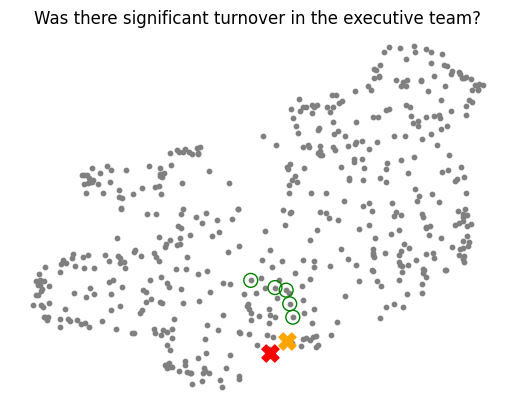

In [26]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Augment the query with additional queries.

In [27]:
def augment_multiple_query(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about an annual report.\n'
    f'Suggest up to five additional related questions to help them find the information they need, for the provided question.\n'
    f'Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\n'
    f'Make sure they are complete questions, and that they are related to the original question.\n'
    f'Output one question per line. Do not number the questions.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query, model)

joint_query = f"{original_query} \n{augmented_queries}"
print(joint_query)

What were the most important factors that contributed to increases in revenue? 
What were the company's main sources of revenue?
How much revenue did each product or service generate?
Did the company experience any significant changes in its customer base?
How did the company's pricing strategy impact its revenue?
Did the company benefit from any favorable economic conditions?


Retrieve answers for all of these queries.


In [28]:
queries = [original_query] + augmented_queries.split('\n')
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
. due to these factors and the evolving nature of our business, our historical revenue growth rate and historical operating margin may not be indicative of our future performance. for additional information, see trends in our business and financial effect and revenues and monetization metrics in part ii, item 7 of this annual report on form 10 - k.

our revenue growth rate could decline over time, and we anticipate downward pressure on our operating margin in the future. our revenue growth rate could decline over time as a result of a number of factors, including changes in the devices and modalities used to access our products and services ; changes in geographic mix ; deceleration or declines in advertiser spending ; competition ; customer usage and demand for our products ; decreases in our pricing of our products and services ; ongoing product and policy changes ; and shifts to lower pri

Project the queries embeddings into a 2-dimensional space

In [29]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 299/299 [00:01<00:00, 179.66it/s]


Now project the answer embeddings.

In [30]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:00<00:00, 48.06it/s]


Plot the queries and answers.

(-1.4102312833070756, 8.613915792107582, 1.0237262845039368, 8.612713277339935)

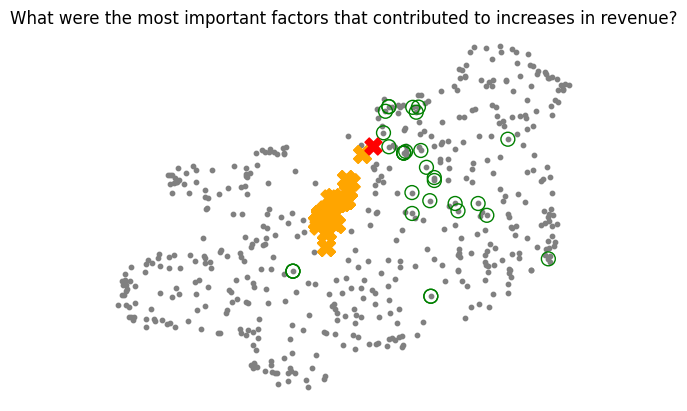

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Re-ranking results

With the query expansion technique that we just discussed, we increased the cardinality of responses. We have a new problem now. The high amount of responses might be larger than the LLM's input token limit and, it will be more expensive to process such a high amount of tokens, since we are billed per token. One solution to this problem is to rerank the results and only send the most relevant ones. Now, instead of using the same cosine-similarity method as before, you could use a cross-encoder, a method that usually yields better results.

In [33]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Create pairs of queries.

In [34]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

Compute and print the similarity between the pairs.

In [35]:
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

Scores:
-7.1594296
-4.6782827
-10.859755
-2.96743
-10.15786
-9.154207
-10.981327
-11.195702
-10.483877
-8.229428
-4.349069
0.4199424
-10.965235
-9.802288
-11.106058
-6.073109
-7.320813
-11.0492
1.3391342
-10.0091
-10.72445
-7.6591444
-9.314676
-4.737796


Reorder the pairs in terms of relevance.

In [36]:
print("New Ordering:")
ranked_docs=['']*len(scores)
i = 0
for position in np.argsort(scores)[::-1]:
    ranked_docs[position] = pairs[i][1]
    i+=1
    print(position)

New Ordering:
18
11
3
10
1
23
15
0
16
21
9
5
22
13
19
4
8
20
2
12
6
17
14
7


Five most relevant:

In [37]:
ranked_docs[:5]

['. to support developers, we launched several new features like custom store listings, a new way to reach a specific segment of people with messaging relevant to them, so they can expand their businesses more effectively and efficiently.',
 'we report revenues from google play app sales and in - app purchases on a net basis, because our performance obligation is to facilitate a transaction between app developers and end users, for which we earn a service fee. arrangements with multiple performance obligations our contracts with customers may include multiple performance obligations. for such arrangements, we allocate revenues to each performance obligation based on its relative standalone selling price. we generally determine standalone selling prices based on the prices charged to customers. customer incentives and credits certain customers receive cash - based incentives or credits, which are accounted for as variable consideration. we estimate these amounts based on the expected am

Only send the most relevant answers to the LLM

In [38]:
response = rag(query=original_query, retrieved_documents=ranked_docs[:5], model=model)
print(original_query)
print(response)

What were the most important factors that contributed to increases in revenue?
## Key Factors Contributing to Revenue Growth:

Based on the provided information, the most important factors contributing to increases in revenue for Alphabet Inc. are:

**1. App Store Enhancements:**

* The launch of new features like custom store listings and targeted messaging significantly improved the ability of developers to reach and engage users, leading to increased app sales and in-app purchases.

**2. Google Play Services:**

* The report highlights the significant revenue generated through Google Play app sales and in-app purchases. These services provide a platform for developers to monetize their apps and contribute to Alphabet's overall revenue growth.

**3. Advertising Revenue:**

* The report mentions advertising revenues generated by Google Search & Other Properties, Google Network Properties, and YouTube Properties as the largest source of cash provided by operating activities. This indic

## Embedding Adapters

Another improvement that we can make is instead of getting more answers and reranking, train the embedding model to work with our dataset based on user queries. This is a form a of fine tuning that you can do on your own.

Generate queries that might be asked to a financial statement. If you had real users, you would use those queries instead of making them up.

In [40]:
def generate_queries(model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'Suggest 10 to 15 short questions that are important to ask when analyzing an annual report.\n'
    f'Do not output any compound questions (questions with multiple sentences or conjunctions).\n'
    f'Output each question on a separate line divided by a newline.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text.split('\n')

generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)

## Important questions for analyzing an annual report:

1. What is the company's primary business activity?
2. What are the company's main sources of revenue?
3. How has the company's revenue trended over the past few years?
4. What are the company's main expenses?
5. How has the company's profitability changed over the past few years?
6. What is the company's debt-to-equity ratio?
7. How much cash does the company have on hand?
8. How much debt does the company have?
9. What are the company's major assets?
10. What are the company's major liabilities?
11. What is the company's outlook for the future?
12. What are the company's key risks and challenges?
13. What are the company's competitive advantages?
14. How does the company's management team compare to its competitors?
15. What are the company's environmental, social, and governance (ESG) initiatives?


Search answers for those queries.

In [41]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

Evaluate the results in 1 for relevant and -1 for irrelevant answers.

In [42]:
def evaluate_results(query, statement, model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'For the given query, evaluate whether the following satement is relevant.\n'
    f'Output only \'yes\' or \'no\'.\n'
    f'Question: {query}, Statement: {statement}.')
    
    responses = model.generate_content(prompt, stream=False)
    if responses.text == 'yes':
        return 1
    return -1

retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

Extract the documents and queries into their own lists.


In [43]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

len(adapter_labels)

100%|██████████| 17/17 [01:51<00:00,  6.57s/it]


170

Install PyTorch so that we can train the embedding model based on relevant answers.


In [44]:
!pip install torch

import torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

Set up the model with cosine similarity, so that embeddings with label 1 are similar and -1 are dissimilar.

In [46]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

Compute the mean squared error (MSE) loss to see how close are we to the expected output.

In [47]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

Initialize the adaptor matrix.

In [48]:
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

Train the adaptor matrix using 100 steps by iteratively update a vector such that if I take that vector and multiply it by these inputs (query embeddings) then compare that result to this vector (this example's retrieved document vector), I get a score closer to (this example's -1 or 1 label).

In [49]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()       

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Create a scaled vector based on the best matrix that we computed.

In [50]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

Plot the scale vector answers.

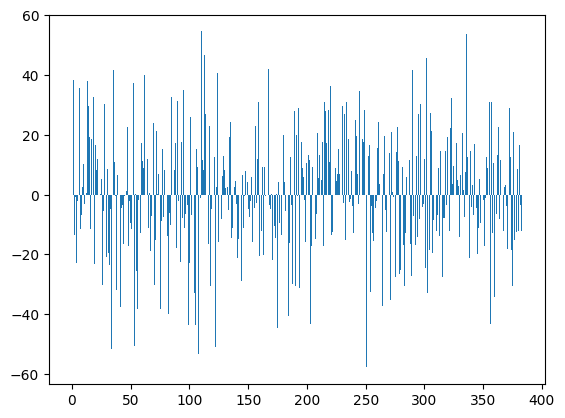

In [51]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

Get the adapted query embeddings to compare them with the original values retrieved.

In [52]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 17/17 [00:00<00:00, 172.91it/s]


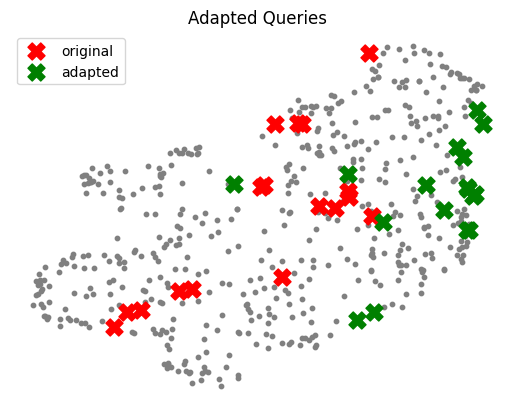

In [53]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()